## Integrantes:
1. Camila Coltriani
2. Luis Dartayet
3. Irania Fuentes
4. Jonathan Fichelson
5. Ornella Cevoli
# Trabajo práctico  4: Analisis de los sentimientos en Twitter

Intro: Las redes sociales como Twitter han demostrado ser excelentes recursos de información sobre muchos eventos que acontecen en el mundo. Tiene el poder de cambiar las opiniones de millones de personas siendo especialmente útil para influir en las masas: campañas políticas, cotización de monedas virtuales, publicidad de ventas, entre otros.



## Objetivo:
El análisis de los sentimientos se puede utilizar para predecir el comportamiento de personas y propagar cambios en tiempo real a medida que se desarrolla el evento que se quiere estudiar.

Predecir la probabilidad de que un individuo tweetee en un tweet positivo o negativo dependiendo del día de la semana.

NO SE REALMENTE, NO ESTOY TAN SEGURO EN BASE AL GRÁFICO.



_______________________________________

In [1]:
# Librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score,plot_confusion_matrix,roc_auc_score, classification_report, confusion_matrix, precision_recall_curve, auc
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from scipy.stats import mode
import seaborn as sns
import re

# nltk
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer


from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV,StratifiedKFold,train_test_split
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline




## Importación

BAJAR DATASET DE KAGGLE, RENOMBRARLO COMO TWITTER Y PONERLO EN LA CARPETA DATA

In [2]:
data = pd.read_csv('./data/twitter.csv', encoding='ANSI')
data.columns = [ 'target', 'id', 'date', 'flag', 'user', 'text']
print(data.shape)
data.head()

(1599999, 6)


,target,id,date,flag,user,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [ ]:
# Get empty values
data.isnull().sum()


In [ ]:
data[data.duplicated() == True]

In [3]:
# Set day of week as category
data['date'] = data['date'].str[:3].astype('category')
data['date'].cat.categories = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
data.head()


,target,id,date,flag,user,text
0,0,1467810672,Tue,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Tue,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Tue,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Tue,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Tue,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [ ]:
# Get the number of tweets per day and target
data.groupby(['date', 'target']).size()

In [ ]:
# Plot the number of tweets per day and target with a bar chart
# {0: 'Negative', 2: 'Neutral', 4: 'Positive'}
data.groupby(['date', 'target']).size().unstack().plot(kind='bar',  figsize=(10, 5))
plt.title('Number of tweets per day and target')
plt.xlabel('Day of week')
plt.ylabel('Number of tweets')
plt.show()



## Preprocesamiento de texto

### Limpieza del corpus

### Remoción de Stopwords y aplicación de Stemming

In [4]:
# Expresion regular para eliminar del corpus signos de puntación/ @/ direcciones electronicas #numeros
limpieza_re = "\d+[^0-9]|@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]"

In [5]:
#Remoción de Stopwords y aplicación de Stemming
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

#Funcion para limpiar el corpus
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(limpieza_re, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

data.text = data.text.apply(lambda x: preprocess(x))

In [ ]:
data.text

Division de los datos en train y test

In [6]:
#Asignamos las variables X e Y a modelar
X = data.text
y = data.target

In [8]:
#Dividimos en train-test
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y, test_size=0.3, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1119999,)
(480000,)
(1119999,)
(480000,)


In [9]:
#Usamos CountVectorizer para lleva nuestro corpus a una matriz de documentos y términos.
vectorizer=CountVectorizer(strip_accents='unicode'); # hay palabras con acentos por error de tipeo o por ser palabras de otro idioma. Los removemos.
# X_train=vectorizer.fit_transform(X_train);
# X_test=vectorizer.transform(X_test);

Configuración del Pipeline

PARA LEER: el primer pipe es con base a la clase 47_1 clasificacion de textos
pipeline para varios modelos viene de aca https://www.youtube.com/watch?v=ES0lM7QBZnI&list=FLrNGJ7KGOB1XGjvk9OvahOw&index=1
que está buena la idea, y lo que se haria luego es usar CV y tunear los hiperparametros sobre el mejor modelo. 

In [ ]:
#armar un pipeline que incluya la verctorizacion y el clasificador para
#optimizar sobre todos los hiperparámetros a la vez.

#ttps://www.kaggle.com/code/balatmak/text-preprocessing-steps-and-universal-pipeline/notebook 

#https://www.kaggle.com/code/balatmak/text-classification-pipeline-newsgroups20/notebook esta notebook está buenisima

In [ ]:
#ESTO ES UNA BASE 

#iniciamos el modelo
#MNB = MultinomialNB()

In [ ]:
# text_tfidf = Pipeline([('vect', CountVectorizer(stop_words='english')), ('tfidf', TfidfTransformer())])
# tfidf_matrix = text_tfidf.fit_transform(texts_all_train)
#https://www.kaggle.com/code/benboyet/web-mining-project-final-prediction/script

In [10]:
#Código de pipe la verctorizacion y el clasificador para optimizar sobre todos los hiperparámetros a la vez con gridsearch

pasos=[('vect',vectorizer),('classifier',MultinomialNB())]
pipe=Pipeline(pasos)

#Definimos TFIDvectorizer
vectorizer=TfidfVectorizer(stop_words=stop_words,strip_accents='unicode'); #ngram_range=(1,2)

#definimos la validacion cruzda
skf=StratifiedKFold(n_splits=3,random_state=0,shuffle=True)

#parametros del grid         ##usar otros valores
params_grid={'classifier__alpha':[1,2,1.5],'vect__min_df':[1,3]}; #frecuencia menor al dado


#entrenamos el modelo
GS_CV=GridSearchCV(pipe,params_grid,cv=skf,verbose=1,n_jobs=-1);

GS_CV.fit(X_train, y_train);

print('best score:',GS_CV.best_score_)
print('best params:',GS_CV.best_params_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
best score: 0.7665774701584555
best params: {'classifier__alpha': 2, 'vect__min_df': 1}


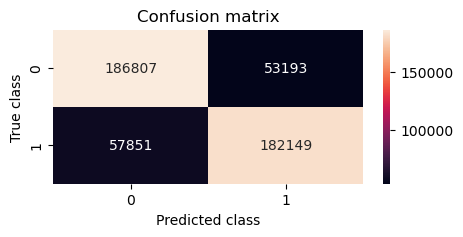

In [11]:
pipe_pred = GS_CV.predict(X_test)

conf_matrix = confusion_matrix(y_test, pipe_pred); 
plt.figure(figsize=(5, 2)); sns.heatmap(conf_matrix,  annot=True, fmt="d");
plt.title("Confusion matrix"); plt.ylabel('True class'); plt.xlabel('Predicted class');plt.show()

In [12]:
#reporte de clasificación
print(classification_report(y_test, pipe_pred))

              precision    recall  f1-score   support

           0       0.76      0.78      0.77    240000
           4       0.77      0.76      0.77    240000

    accuracy                           0.77    480000
   macro avg       0.77      0.77      0.77    480000
weighted avg       0.77      0.77      0.77    480000



In [13]:
#modelo final con parametros seteados

vectorizer_2=TfidfVectorizer(stop_words=stop_words,strip_accents='unicode', min_df=1);
MNB = MultinomialNB(alpha=2,)
pasos_2=[('vectorizer',vectorizer_2),('MNB',MNB)]

In [14]:
#configurar pipe
pipe_2 = Pipeline(pasos_2)
pipe_2.fit(X_train, y_train)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...],
                                 strip_accents='unicode')),
                ('MNB', MultinomialNB(alpha=2))])

In [15]:
pipe_2_pred= pipe_2.predict(X_test)

In [20]:
X_test

204895     work library bad pay amazing boring sometimes ...
577089                            naw man found phone slower
818027                                          yay exciting
50717                         almost done paper study finals
866514       beautiful day today fantastic day jules addison
                                 ...                        
1448877    listening alesana grrr hate work school tomoro...
1245971                                      hey u ihts nice
585402            live tweet streaming sytycd miss dena lisa
341357     hope everybody great day doin wateva dey gotta...
1395053    wow must amazing feeling seeing ya oct cant wa...
Name: text, Length: 480000, dtype: object

In [16]:
#reporte de clasificación
print(classification_report(y_test, pipe_2_pred))

              precision    recall  f1-score   support

           0       0.76      0.77      0.77    240000
           4       0.77      0.76      0.76    240000

    accuracy                           0.76    480000
   macro avg       0.76      0.76      0.76    480000
weighted avg       0.76      0.76      0.76    480000



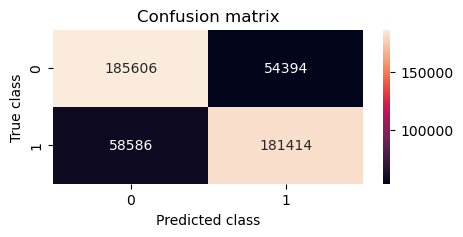

In [17]:
conf_matrix = confusion_matrix(y_test, pipe_2_pred); 
plt.figure(figsize=(5, 2)); sns.heatmap(conf_matrix,  annot=True, fmt="d");
plt.title("Confusion matrix"); plt.ylabel('True class'); plt.xlabel('Predicted class');plt.show()

In [ ]:
pipe_2_pred= pipe_2.predict(X_test)

"pipeline para varios modelos"

In [ ]:
pipeline_lr = Pipeline([('vect',vectorizer),
                        ('lr_classifier',LogisticRegression())])

In [ ]:
pipeline_knn = Pipeline([('vect',vectorizer),
                        ('knn_classifier',KNeighborsClassifier())])

In [ ]:
#lista de pipelines
pipelines = [pipeline_lr, pipeline_knn]

In [ ]:
best_accuracy=0.0
best_classifier=0
best_pipeline=""

In [ ]:
#diccionario de pipeline y tipos de clasificador para referencia
pipe_dict = {0: "Logistc Regresion", 1:"knn"}

#entrenamiento 
for pipe in pipelines:
    pipe.fit(X_train, y_train)

In [ ]:
for i, model in enumerate(pipelines):
    print("{} Accuracy para el conjunto de prubea: {}".format(pipe_dict[i], model.score(X_test, y_test)))

### Wordcloud

In [ ]:
#https://www.kaggle.com/code/mskorski/topic-extraction-and-visualization-musk-s-tweets

### Tokenización

### Remoción de stopwords

### Lematización/ Stemming

### Vectorización

### TF-IDF

### Word2Vec

### Singular Value Decomposition 

## Modelos